## **Model Selection and Bulding**

In this notebook I'll be selecting and building some machine learning models for the dataset that we previously got from the exploratory analysis notebook. 

---

In [1]:
import pandas as pd

In [2]:
# Loading the dataframe from our pipeline and exploratory analysis

df = pd.read_parquet("datasets/3c_like_proteinase_molecular_descriptors.parquet")

In [3]:
display(df)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,morgan_fp_0,morgan_fp_1,...,morgan_fp_1014,morgan_fp_1015,morgan_fp_1016,morgan_fp_1017,morgan_fp_1018,morgan_fp_1019,morgan_fp_1020,morgan_fp_1021,morgan_fp_1022,morgan_fp_1023
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0,5,5.142668,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0,2,5.026872,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0,4,4.869666,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0,3,4.882397,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0,5,5.698970,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,338.359,3.40102,0,5,4.974694,0,0,...,0,0,0,0,0,0,0,0,0,0
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,296.366,3.44330,0,3,4.995679,0,0,...,0,0,0,0,0,1,0,0,0,0
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,276.291,4.09564,0,3,4.939302,0,0,...,0,0,0,0,0,0,0,0,0,0
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,278.307,3.29102,0,3,4.970616,0,0,...,0,0,0,0,0,1,0,0,0,0


## Augmenting the dataset by using SMILES enumeration

We can augment our dataset by generating multiple valid representations of the same molecule in the SMILES (Simplified Molecular Input Line Entry System) format by shuffling the order of atoms or bonds in the molecule. These enumerations are chemically equivalent but provide more variety for the machine learning model to learn from.

In [4]:
from rdkit import Chem
from rdkit.Chem import MolToSmiles, MolFromSmiles

# Function to perform SMILES enumeration
def enumerate_smiles(smiles, num_enumerations=1):
    mol = MolFromSmiles(smiles)
    enumerated_smiles = set()
    
    for _ in range(num_enumerations):
        # Generate random SMILES (shuffled atoms/bonds)
        random_smiles = MolToSmiles(mol, doRandom=True)
        enumerated_smiles.add(random_smiles)
    
    return list(enumerated_smiles)

# Function to augment dataset with enumerated SMILES
def augment_dataset_with_smiles(df, smiles_column='smiles', num_enumerations=1):
    augmented_data = []
    
    for idx, row in df.iterrows():
        smiles = row[smiles_column]
        enumerated_smiles = enumerate_smiles(smiles, num_enumerations)
        
        for enum_smiles in enumerated_smiles:
            new_row = row.copy()
            new_row[smiles_column] = enum_smiles
            augmented_data.append(new_row)
    
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

In [5]:
# Augment dataset with 5 SMILES enumerations per molecule
augmented_df = augment_dataset_with_smiles(df, smiles_column='canonical_smiles', num_enumerations=1)

In [6]:
display(augmented_df)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,morgan_fp_0,morgan_fp_1,...,morgan_fp_1014,morgan_fp_1015,morgan_fp_1016,morgan_fp_1017,morgan_fp_1018,morgan_fp_1019,morgan_fp_1020,morgan_fp_1021,morgan_fp_1022,morgan_fp_1023
0,CHEMBL187579,Cc1noc(C)c1CN1c2ccc(C#N)cc2C(=O)C1=O,intermediate,281.271,1.89262,0,5,5.142668,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL188487,Clc1c(ccc(F)c1)CN1C(C(c2cc(ccc12)I)=O)=O,intermediate,415.589,3.81320,0,2,5.026872,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL185698,C1(=O)N(c2c(C1=O)cc(I)cc2)CC1COc2c(O1)cccc2,inactive,421.190,2.66050,0,4,4.869666,0,0,...,0,0,0,0,0,1,0,0,0,0
3,CHEMBL426082,c1c2c(ccc1)N(C(=O)C2=O)Cc1sc2c(c1)cccc2,inactive,293.347,3.63080,0,3,4.882397,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL187717,c1cc([N+](=O)[O-])c2c(c1)C(C(N2Cc1sc2c(c1)cccc...,intermediate,338.344,3.53900,0,5,5.698970,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,C1Cc2c(ccc3c2C(C(=O)c2c(coc-32)C)=O)[C@@](C(=O...,inactive,338.359,3.40102,0,5,4.974694,0,0,...,0,0,0,0,0,0,0,0,0,0
129,CHEMBL187460,C1C(C)(c2ccc3C4OC[C@H](C)C=4C(=O)C(=O)c3c2CC1)C,inactive,296.366,3.44330,0,3,4.995679,0,0,...,0,0,0,0,0,1,0,0,0,0
130,CHEMBL363535,c12C(=O)C(=O)c3c(-c2occ1C)ccc1c3cccc1C,inactive,276.291,4.09564,0,3,4.939302,0,0,...,0,0,0,0,0,0,0,0,0,0
131,CHEMBL227075,C1(C2[C@@H](C)COC=2c2ccc3c(cccc3c2C1=O)C)=O,inactive,278.307,3.29102,0,3,4.970616,0,0,...,0,0,0,0,0,1,0,0,0,0


In [7]:
augmented_df = augmented_df[["canonical_smiles", "pIC50"]]

In [8]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

# Create the Morgan fingerprint generator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

# Function to generate Morgan fingerprints using the new generator
def morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to RDKit molecule
    if mol:
        fp = morgan_gen.GetFingerprint(mol)  # Get the fingerprint as an RDKit object
        return np.array(fp)  # Convert to a NumPy array (1s and 0s)
    else:
        return np.zeros(1024)  # Return a zero vector if molecule creation fails

In [9]:
augmented_df['morgan_fingerprint'] = augmented_df['canonical_smiles'].apply(morgan_fingerprint)

# Convert the Morgan fingerprints (which are arrays) into individual columns
fingerprint_df = pd.DataFrame(augmented_df['morgan_fingerprint'].tolist(), index=augmented_df.index)

# Rename the columns to "MorganFPn" where n is the bit number, and ensure the values are integers
fingerprint_df.columns = [f'morgan_fp_{i}' for i in range(fingerprint_df.shape[1])]
fingerprint_df = fingerprint_df.astype(int)

# Concatenate the original dataframe with the new fingerprint columns
augmented_df = pd.concat([augmented_df.drop(columns=['morgan_fingerprint']), fingerprint_df], axis=1)

In [10]:
display(augmented_df)

,canonical_smiles,pIC50,morgan_fp_0,morgan_fp_1,morgan_fp_2,morgan_fp_3,morgan_fp_4,morgan_fp_5,morgan_fp_6,morgan_fp_7,...,morgan_fp_1014,morgan_fp_1015,morgan_fp_1016,morgan_fp_1017,morgan_fp_1018,morgan_fp_1019,morgan_fp_1020,morgan_fp_1021,morgan_fp_1022,morgan_fp_1023
0,Cc1noc(C)c1CN1c2ccc(C#N)cc2C(=O)C1=O,5.142668,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Clc1c(ccc(F)c1)CN1C(C(c2cc(ccc12)I)=O)=O,5.026872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C1(=O)N(c2c(C1=O)cc(I)cc2)CC1COc2c(O1)cccc2,4.869666,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,c1c2c(ccc1)N(C(=O)C2=O)Cc1sc2c(c1)cccc2,4.882397,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,c1cc([N+](=O)[O-])c2c(c1)C(C(N2Cc1sc2c(c1)cccc...,5.698970,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,C1Cc2c(ccc3c2C(C(=O)c2c(coc-32)C)=O)[C@@](C(=O...,4.974694,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,C1C(C)(c2ccc3C4OC[C@H](C)C=4C(=O)C(=O)c3c2CC1)C,4.995679,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
130,c12C(=O)C(=O)c3c(-c2occ1C)ccc1c3cccc1C,4.939302,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,C1(C2[C@@H](C)COC=2c2ccc3c(cccc3c2C1=O)C)=O,4.970616,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [11]:
# Selecting only pIC50 and fingerprints columns
df = df.filter(regex="^(morgan|pIC50)").reset_index()

In [12]:
display(df)

,index,pIC50,morgan_fp_0,morgan_fp_1,morgan_fp_2,morgan_fp_3,morgan_fp_4,morgan_fp_5,morgan_fp_6,morgan_fp_7,...,morgan_fp_1014,morgan_fp_1015,morgan_fp_1016,morgan_fp_1017,morgan_fp_1018,morgan_fp_1019,morgan_fp_1020,morgan_fp_1021,morgan_fp_1022,morgan_fp_1023
0,0,5.142668,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5.026872,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4.869666,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,4.882397,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5.698970,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,128,4.974694,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,129,4.995679,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
130,130,4.939302,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131,131,4.970616,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
# Removing low variance features that don't provide much useful information for prediction

X = df.drop("pIC50", axis=1)

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold= 0.8 * (1 - 0.8))
X_reduced = selector.fit_transform(X)

# Convert X_reduced back to a DataFrame for compatibility with PyCaret
X_reduced = pd.DataFrame(X_reduced)

# Add the target column back to the reduced feature set
df_reduced = pd.concat([X_reduced, df['pIC50']], axis=1)

### **Testing muliple models with PyCaret**

PyCaret is an automated machine learning library that allows us to test multiple machine learning models on our dataset and selects the best one based on the evaluation metric specified in the setup.

One of PyCaret’s advantages is its ability to handle data preprocessing automatically. This includes tasks such as splitting the data into training and testing sets, handling missing values, and removing low variance features, so we don’t need to manually configure these steps.

Since our dataset is small (133 rows) and we are working on a regression problem, we will use an 80%/20% train-test split and employ 5-fold cross-validation to avoid underfitting or overfitting. We will focus on the Root Mean Squared Error (RMSE) score as the metric to select the model that penalizes larger prediction errors more heavily, since we are working with drug discovery.

In [14]:
from pycaret.regression import setup, compare_models

# Initialize PyCaret's setup function
reg = setup(data=df_reduced, target='pIC50', train_size=0.8, fold=10, session_id=333)

# Compare different models and select the best one
best_model = compare_models(sort="RMSE")

,Description,Value
0,Session id,333
1,Target,pIC50
2,Target type,Regression
3,Original data shape,"(133, 47)"
4,Transformed data shape,"(133, 47)"
5,Transformed train set shape,"(106, 47)"
6,Transformed test set shape,"(27, 47)"
7,Numeric features,46
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3416,0.2080,0.4429,0.6826,0.0762,0.0726,0.0330
gbr,Gradient Boosting Regressor,0.3281,0.2269,0.4595,0.6499,0.0762,0.0674,0.0170
ada,AdaBoost Regressor,0.3836,0.2454,0.4831,0.6296,0.0827,0.0821,0.0170
lightgbm,Light Gradient Boosting Machine,0.3962,0.2623,0.4994,0.6123,0.0872,0.0846,0.0200
knn,K Neighbors Regressor,0.3921,0.2979,0.5176,0.5678,0.0877,0.0815,0.0220
br,Bayesian Ridge,0.4632,0.3198,0.5550,0.5412,0.0976,0.1006,0.0070
ridge,Ridge Regression,0.4544,0.3371,0.5656,0.5129,0.1003,0.0982,0.0080
et,Extra Trees Regressor,0.3871,0.4219,0.6111,0.3422,0.1025,0.0803,0.0280
omp,Orthogonal Matching Pursuit,0.4976,0.3979,0.6232,0.3678,0.1060,0.1046,0.0070
dt,Decision Tree Regressor,0.4287,0.4262,0.6313,0.2969,0.1081,0.0901,0.0060


## **Interpretation**

The AdaBoost Regressor model seems to have the best performance overall, with the lowest RMSE (0.4827), MSE (0.2405), and the highest R² (0.6680), indicating it's the best model in terms of explaining the variance in the data and penalizing wrong predictions.

## **Model Fine-Tuning**

Now that we tested multiple models against our dataset, it's time to fine-tune the best performing one. For this step I'll be optimizing **Bayesian Ridge Model** hyperparameters also utilizing PyCaret, that automates this process.

In [15]:
from pycaret.regression import tune_model

# PyCaret already stores best performing model in the variable, so we just need to fine-tune it
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4524,0.3449,0.5873,0.4953,0.0954,0.0877
1,0.5158,0.4526,0.6728,0.4971,0.1238,0.1254
2,0.4777,0.4305,0.6561,0.5221,0.0976,0.0883
3,0.3200,0.1596,0.3995,0.7020,0.0740,0.0708
4,0.5575,0.4340,0.6588,0.4657,0.1279,0.1425
5,0.4971,0.3746,0.6121,0.7410,0.0979,0.0991
6,0.6067,0.5970,0.7727,0.2733,0.1282,0.1191
7,0.3397,0.1480,0.3848,0.4934,0.0707,0.0774
8,0.3424,0.1579,0.3974,0.7401,0.0652,0.0687


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [16]:
from pycaret.regression import predict_model, evaluate_model
# Evaluate the tuned model
evaluate_model(tuned_model)

# Get predictions on a test set
predictions = predict_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3168,0.2525,0.5025,0.7016,0.0802,0.0615


In [17]:
display(predictions.head())

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,pIC50,prediction_label
100,100,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,7.200659,7.035244
75,75,1,1,1,1,0,1,1,1,0,...,1,0,0,1,1,0,1,1,4.958607,4.901892
36,36,1,1,1,1,1,1,1,1,0,...,1,0,0,1,1,0,1,1,4.390000,4.449907
18,18,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,4.602060,4.564638
68,68,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,0,1,1,4.520000,4.067702


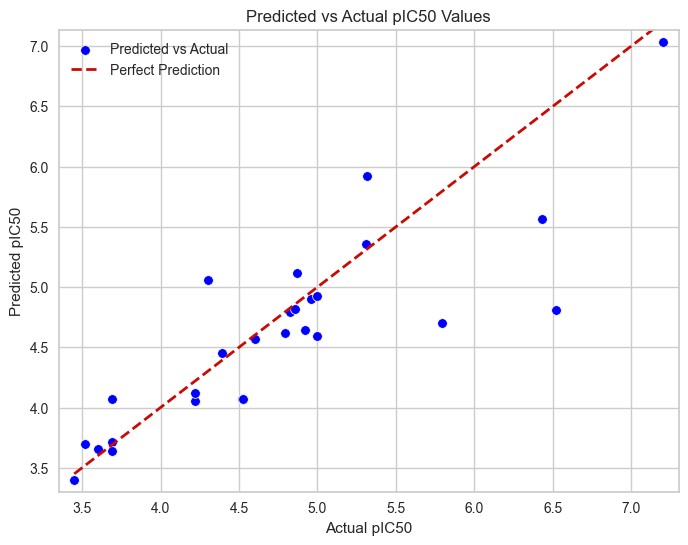

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the actual and predicted values
actual_values = predictions['pIC50']
predicted_values = predictions['prediction_label']

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual_values, y=predicted_values, color="blue", label="Predicted vs Actual")

# Add a line for perfect predictions
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'r--', lw=2, label="Perfect Prediction")

# Set axis limits to make sure the scales match
plt.xlim([actual_values.min() - 0.1, actual_values.max() + 0.1])
plt.ylim([predicted_values.min() - 0.1, predicted_values.max() + 0.1])

# Add labels and title
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Predicted vs Actual pIC50 Values")
plt.legend()
plt.show()

## **Saving the model**

Now that our model is fine-tuned it's time to save it to use!

In [19]:
from pycaret.regression import save_model

# Save the tuned model to a file
save_model(tuned_model, 'fine_tuned_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  RandomForestRegressor(n_jobs=-1, random_state=333))]),
 'fine_tuned_model.pkl')